# 活動量と相関関係
## このノートブックで何をするのか
イリノイ州でのロックダウンや自宅待機勧告が出ている際に、そのほかの時期との活動量に相関があるのかを検証する。
これは、先行研究でのレプリケーションにもなり、ここでの結果をそのまま記載できるという目論見もある。

## 具体的に何をするのか
- 活動量とタイムスタンプだけのデータセットを作成する（もう既にあるかもしれない）  
- ロックダウンと自宅待機勧告、それ以外に分割する
- それぞれに対して、相関係数を計算する
- 有意かどうかを見る


In [2]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import random

from scipy import stats, integrate, optimize, special, interpolate

In [3]:
# dfの読み込み
df = pd.read_pickle('../data/df.pickle')

In [4]:
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [5]:
# 分割する　ロックダウンと通常時
df_lockdown = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] <= "2020-12-31")]

In [6]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [7]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [8]:
node_lockdown, edge_lockdown, timestamp_lockdown = getNetworkAnalysis(df_lockdown)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)

In [9]:
Np = 1416
alpha_list = []
beta_list = []

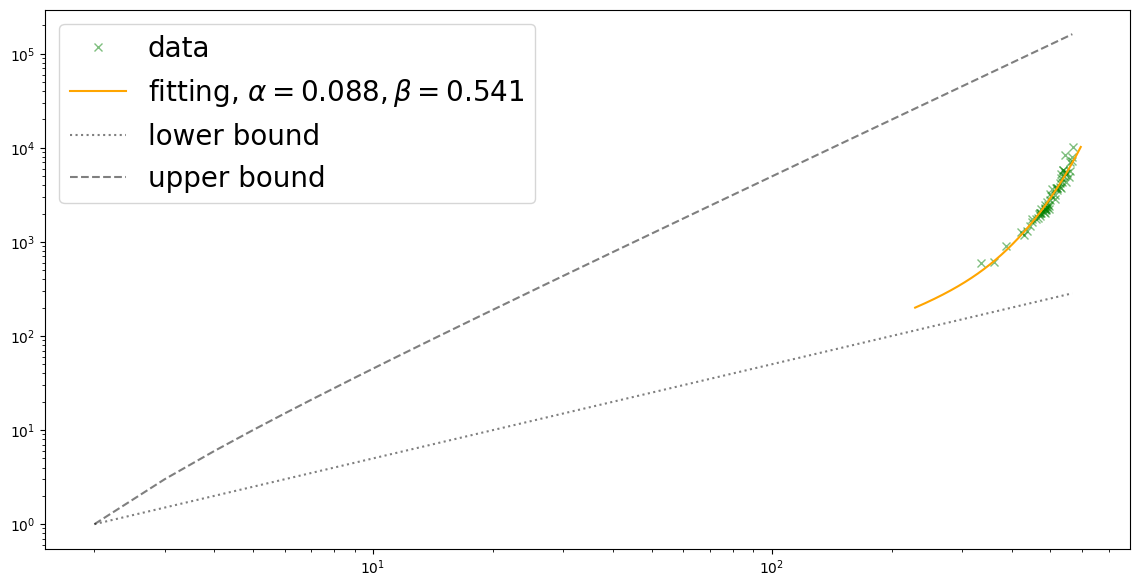

In [11]:
plt.figure(figsize=(14,7))

N = node_lockdown
M = edge_lockdown # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha_list.append(alpha)
beta_list.append(beta)

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

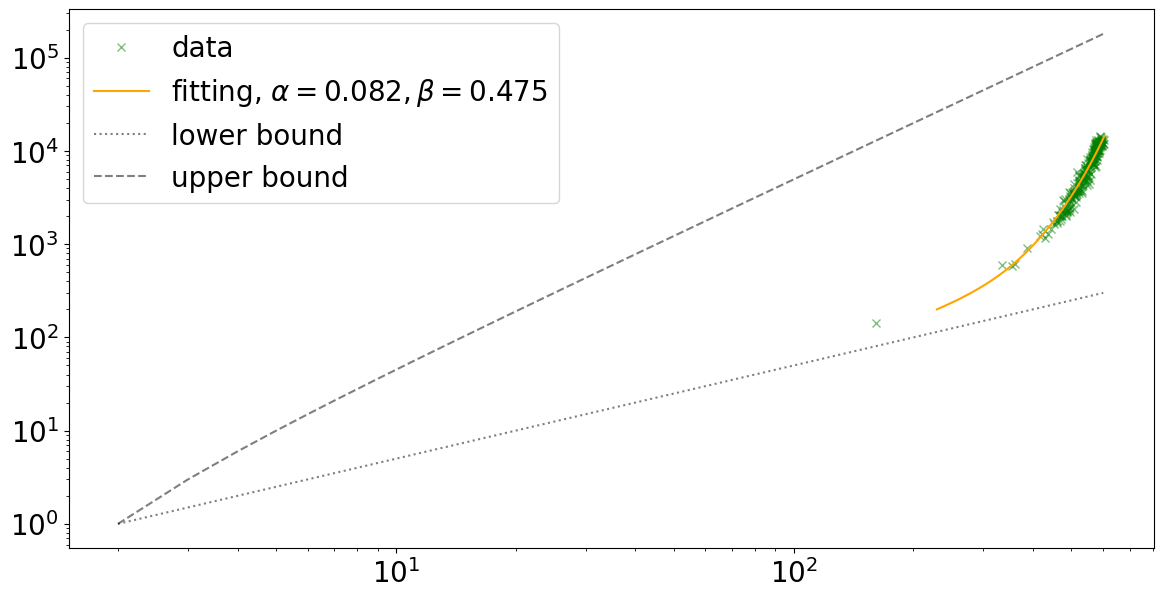

In [12]:
plt.figure(figsize=(14,7))

N = node_2020
M = edge_2020

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha_list.append(alpha)
beta_list.append(beta)

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

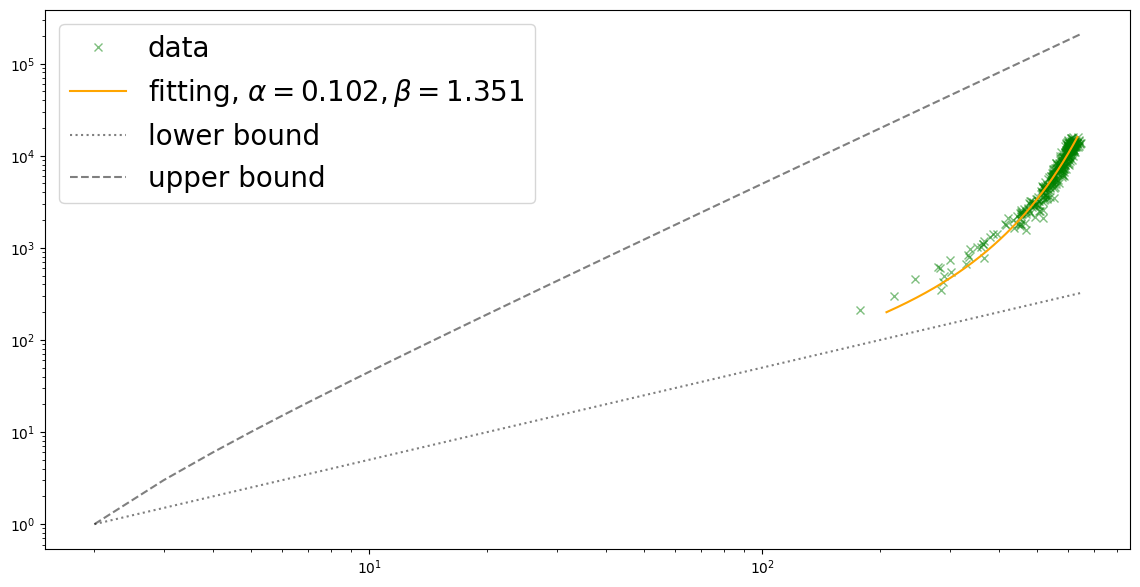

In [13]:
plt.figure(figsize=(14,7))

N = node_2021
M = edge_2021 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha_list.append(alpha)
beta_list.append(beta)

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

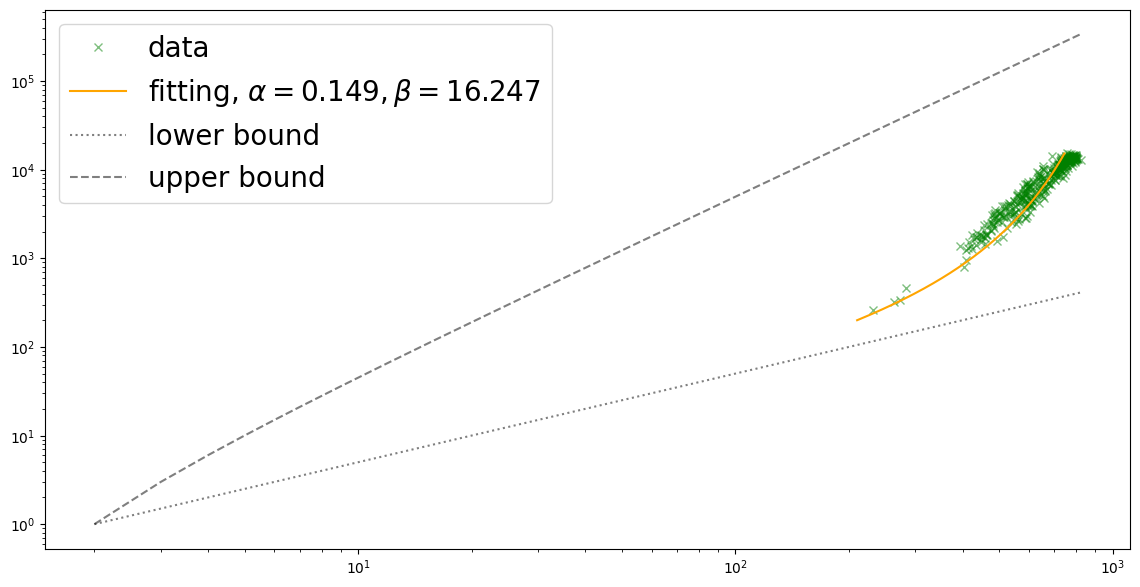

In [14]:
plt.figure(figsize=(14,7))

N = node_2022
M = edge_2022 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha_list.append(alpha)
beta_list.append(beta)

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

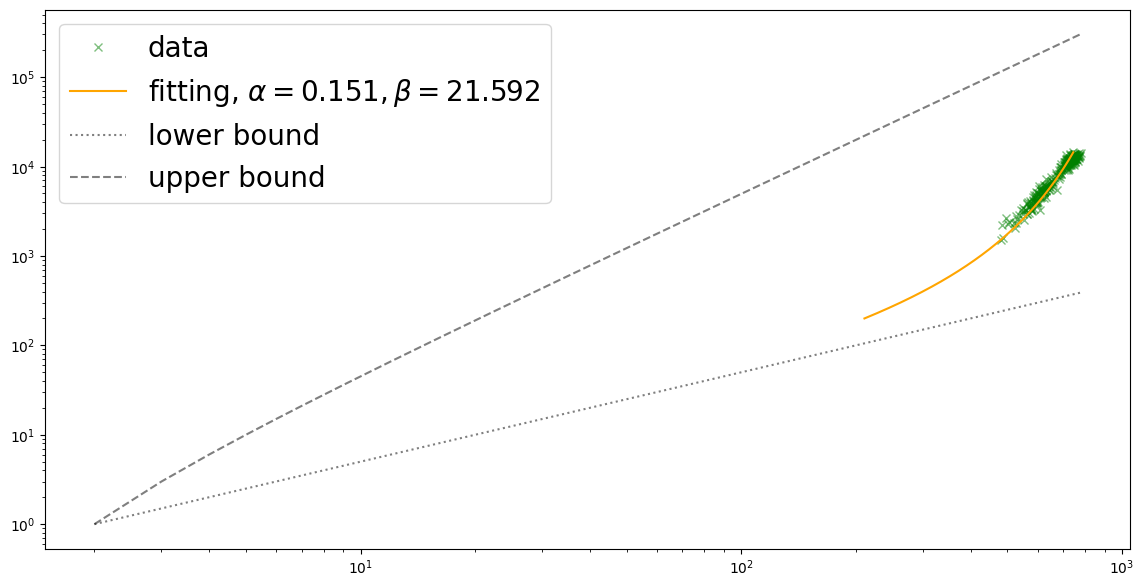

In [15]:
plt.figure(figsize=(14,7))

N = node_2023
M = edge_2023 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha_list.append(alpha)
beta_list.append(beta)

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

In [16]:
print("alpha_list: ", alpha_list)
print("beta_list: ", beta_list)

alpha_list:  [0.08164716573334053, 0.087712349274334, 0.08164716573334053, 0.10185471898630084, 0.14897453953493767, 0.15109222888369586]
beta_list:  [0.4748170257963169, 0.5410837338046393, 0.4748170257963169, 1.3514615090459583, 16.24674273972615, 21.592221530636355]


In [17]:
# 活動量を計算する
kappa_list_lockdown = []
for i in range(len(edge_lockdown)):
    alpha = alpha_list[0]
    beta = beta_list[0]
    kappa_list_lockdown.append(kappa(edge_lockdown[i], Np))

kappa_list_2020 = []
for i in range(len(edge_2020)):
    alpha = alpha_list[1]
    beta = beta_list[1]
    kappa_list_2020.append(kappa(edge_2020[i], Np))

kappa_list_2021 = []
for i in range(len(edge_2021)):
    alpha = alpha_list[2]
    beta = beta_list[2]
    kappa_list_2021.append(kappa(edge_2021[i], Np))

kappa_list_2022 = []
for i in range(len(edge_2022)):
    alpha = alpha_list[3]
    beta = beta_list[3]
    kappa_list_2022.append(kappa(edge_2022[i], Np))

kappa_list_2023 = []
for i in range(len(edge_2023)):
    alpha = alpha_list[4]
    beta = beta_list[4]
    kappa_list_2023.append(kappa(edge_2023[i], Np))

In [19]:
kappa_list_2021_2022_2023 = kappa_list_2021 + kappa_list_2022 + kappa_list_2023

kappa_sampling = np.random.choice(kappa_list_2021_2022_2023, len(kappa_list_lockdown))


In [23]:
print(len(kappa_list_lockdown))
print(len(kappa_sampling))

60
60


In [24]:
# 相関係数を計算する
print("相関係数: ", np.corrcoef(kappa_list_lockdown, kappa_sampling)[0,1])

相関係数:  0.2082370355232665


In [25]:
# 自宅待機勧告時のデータセット
df_stay_11 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] <= "2020-11-30")]
df_stay_12 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2020-12-31")]

In [26]:
node_11, edge_11, timestamp_11 = getNetworkAnalysis(df_stay_11)
node_12, edge_12, timestamp_12 = getNetworkAnalysis(df_stay_12)

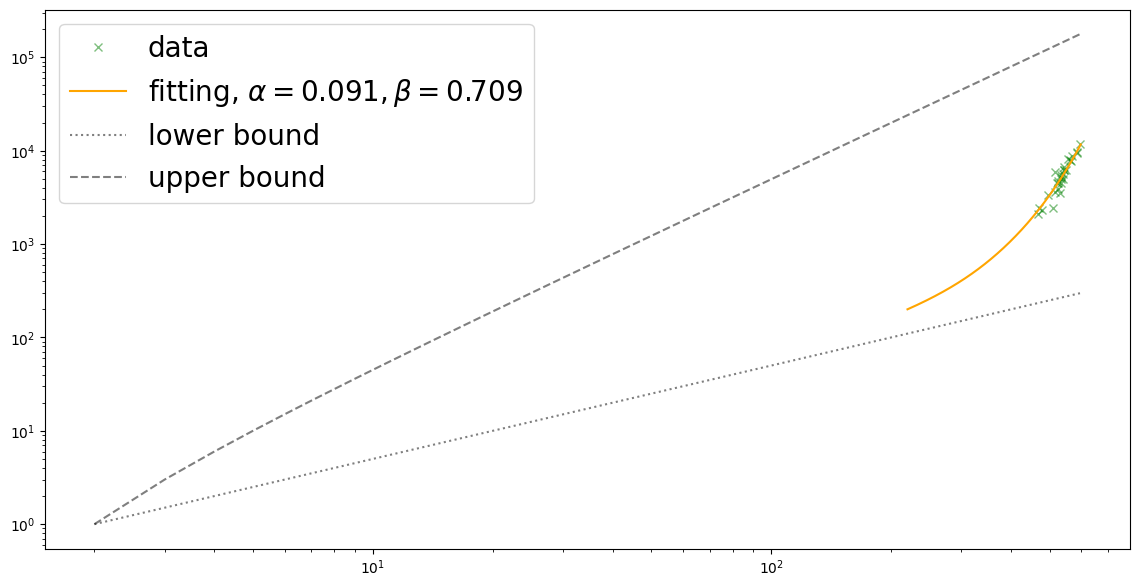

In [29]:
plt.figure(figsize=(14,7))

N = node_11
M = edge_11 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

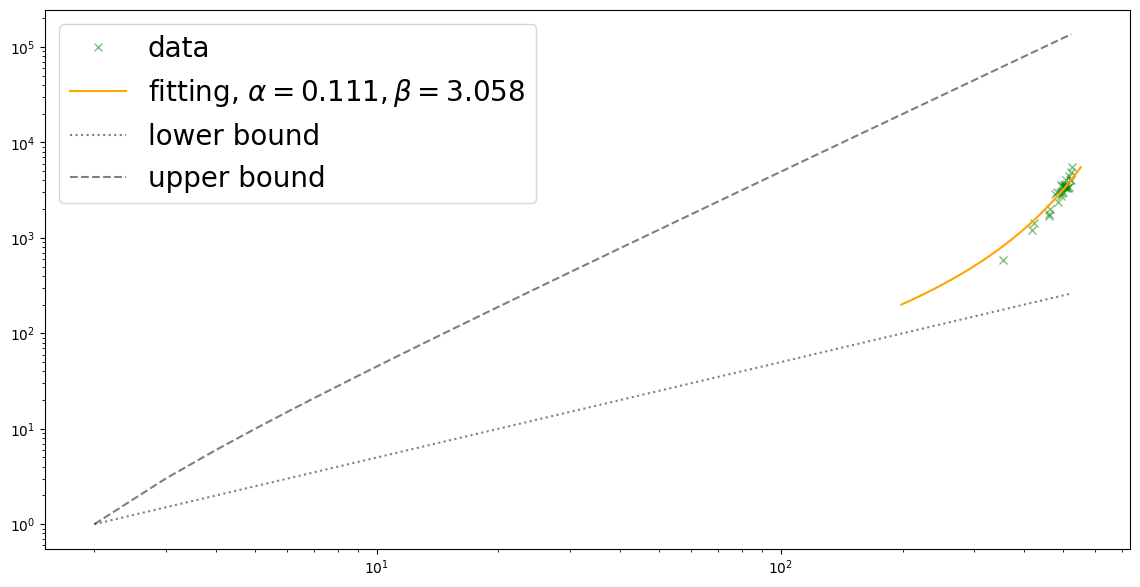

In [28]:
plt.figure(figsize=(14,7))

N = node_12
M = edge_12 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

In [45]:
alpha_stay = [0.091, 0.111]
beta_stay = [0.709, 3.058]

In [95]:
kappa_list_11 = []
for i in range(len(edge_11)):
    alpha = alpha_stay[0]
    beta = beta_stay[0]
    kappa_list_11.append(kappa(edge_11[i], Np))

kappa_list_12 = []
for i in range(len(edge_12)):
    alpha = alpha_stay[1]
    beta = beta_stay[1]
    kappa_list_12.append(kappa(edge_12[i], Np))

kappa_list_11_12 = kappa_list_11 + kappa_list_12
kappa_sampling = random.sample(kappa_list_2021_2022_2023, len(kappa_list_11_12))

In [96]:
# 相関係数を計算する
print("相関係数: ", np.corrcoef(kappa_list_11_12, kappa_sampling)[0,1])

相関係数:  0.05095573845824704


In [72]:
cor_1 = []
for i in range(1000):
    kappa_sampling = np.random.choice(kappa_list_2021_2022_2023, len(kappa_list_lockdown))
    cor_1.append(np.corrcoef(kappa_list_lockdown, kappa_sampling)[0,1])
print("相関係数: ", np.mean(cor_1))

相関係数:  0.005322645441690334


In [20]:
# kappa_2020について
kappa_sampling = np.random.choice(kappa_list_2021_2022_2023, len(kappa_list_2020))

In [21]:
print("相関係数: ", np.corrcoef(kappa_list_2020, kappa_sampling)[0,1])

相関係数:  -0.018327623013950446


In [24]:
print(len(kappa_list_2020))

274


In [25]:
print(len(kappa_list_2021_2022_2023))

1000


In [41]:
# kappa_list_2020の数だけkappa_list_2021_2022_2023からランダムにサンプリングする
kappa_ansamble = []
for i in range(1000):
    kappa_sampling = random.sample(kappa_list_2021_2022_2023, len(kappa_list_2020))
    kappa_ansamble.append(np.corrcoef(kappa_list_2020, kappa_sampling)[0,1])
  
print("相関係数: ", np.mean(kappa_ansamble))


相関係数:  0.0018202290827993104
